In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

df = pd.read_csv(r'Z:\projects\AutoAugmentation-system\data\timeseries/df_test_all_features.csv')
df = df.T
df.index = pd.to_datetime(df.index)

In [3]:
df = df.interpolate(method='linear') # Это просто для проверки

In [2]:
seq_len = 30 # Размер окна для разбиения и обучения
pred_len = 30 # Количество периода на предсказание по умолчанию
hidden_dim = 64 # Размер латентого простанства
num_layers = 2 # Количество слоев
epochs_auto = 500 # Эпохи на автоэнкодер
epochs_super = 500 # Эпохи на супервизор
epochs_gan = 500 # Эпохи на генератор и дискриминатор
batch_size = 32 # Размер батча
alpha_teacher = 0.7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42) # Зерно torch
np.random.seed(42) # Зерно numpy

In [3]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.values)                # (T, F)
data_tensor = torch.tensor(data_scaled, dtype=torch.float32).to(device)  # (T, F)

def create_sequences(data, seq_len):
    X = []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
    return torch.stack(X)  # (N_windows, seq_len, F)

train_data = create_sequences(data_tensor, seq_len)  # (N, seq_len, F)

#  МОДУЛИ TIMEGAN с LayerNorm
class GRUWithLN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.1):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.ln = nn.LayerNorm(hidden_dim)  # нормализация по hidden_dim
    def forward(self, x):
        # x: (B, T, input_dim)
        h, _ = self.rnn(x)      # h: (B, T, H)
        h = self.ln(h)         # LayerNorm работает по последнему измерению
        return h               # (B, T, H)

class Embedder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.gru_ln = GRUWithLN(input_dim, hidden_dim, num_layers)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
    def forward(self, x):
        h = self.gru_ln(x)
        return torch.tanh(self.fc(h))

class Recovery(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, h):
        return torch.sigmoid(self.fc(h))

class Generator(nn.Module):
    def __init__(self, z_dim, hidden_dim, num_layers):
        super().__init__()
        self.gru_ln = GRUWithLN(z_dim, hidden_dim, num_layers)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
    def forward(self, z):
        h = self.gru_ln(z)
        return torch.tanh(self.fc(h))

class Supervisor(nn.Module):
    def __init__(self, hidden_dim, num_layers):
        super().__init__()
        self.gru_ln = GRUWithLN(hidden_dim, hidden_dim, num_layers)
    def forward(self, h):
        return self.gru_ln(h)

class Discriminator(nn.Module):
    def __init__(self, hidden_dim, num_layers):
        super().__init__()
        self.gru_ln = GRUWithLN(hidden_dim, hidden_dim, num_layers)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, h):
        h = self.gru_ln(h)
        return torch.sigmoid(self.fc(h))

# Инициализация
n_features = df.shape[1]

embedder = Embedder(n_features, hidden_dim, num_layers).to(device)
recovery = Recovery(hidden_dim, n_features).to(device)
generator = Generator(hidden_dim, hidden_dim, num_layers).to(device)
supervisor = Supervisor(hidden_dim, num_layers).to(device)
discriminator = Discriminator(hidden_dim, num_layers).to(device)

loss_fn = nn.MSELoss()

opt_auto = torch.optim.Adam(list(embedder.parameters()) + list(recovery.parameters()), lr=1e-3)
opt_super = torch.optim.Adam(list(supervisor.parameters()) + list(embedder.parameters()), lr=1e-3)
opt_gen = torch.optim.Adam(list(generator.parameters()) + list(supervisor.parameters()), lr=1e-4)
opt_disc = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

# Автоэнкодер
for epoch in range(epochs_auto):
    idx = torch.randint(0, len(train_data), (batch_size,))
    X = train_data[idx]                        # (B, seq_len, F)

    opt_auto.zero_grad()
    H = embedder(X)                            # (B, seq_len, H)
    X_tilde = recovery(H)                      # (B, seq_len, F)
    loss_auto = loss_fn(X_tilde, X)
    loss_auto.backward()
    opt_auto.step()

    if epoch % 100 == 0:
        print(f"Auto Epoch {epoch:04d}: recon_loss={loss_auto.item():.6f}")

# Супервизор
for epoch in range(epochs_super):
    idx = torch.randint(0, len(train_data), (batch_size,))
    X = train_data[idx]
    opt_super.zero_grad()
    H = embedder(X).detach()                   # detach чтобы не трогать автоэнкодер
    H_hat = supervisor(H)                      # (B, seq_len, H)
    loss_sup = loss_fn(H_hat[:, :-1, :], H[:, 1:, :])
    loss_sup.backward()
    opt_super.step()

    if epoch % 100 == 0:
        print(f"Super Epoch {epoch:04d}: sup_loss={loss_sup.item():.6f}")

# Генератор и дискриминатор
for epoch in range(epochs_gan):
    # Эвристический динамический расчет весов (в оригинальном TimeGAN очень сложно с этим, не воспроизвести)
    w_super = min(1.0, 0.01 + epoch / epochs_gan)
    w_adv = min(1.0, 0.01 + epoch / epochs_gan)

    idx = torch.randint(0, len(train_data), (batch_size,))
    X = train_data[idx]
    H_real = embedder(X).detach()              # (B, seq_len, H)

    opt_gen.zero_grad()
    Z = torch.randn_like(H_real)                # (B, seq_len, H)
    H_fake = generator(Z)                       # (B, seq_len, H)
    H_fake_s = supervisor(H_fake)               # (B, seq_len, H)

    Y_fake = discriminator(H_fake)              # (B, seq_len, 1)
    loss_gan = torch.mean((Y_fake - 1) ** 2)    # least-squares GAN
    loss_sup_gen = loss_fn(H_fake_s[:, :-1, :], H_fake[:, 1:, :])
    total_gen_loss = w_adv * loss_gan + w_super * loss_sup_gen
    total_gen_loss.backward()
    opt_gen.step()

    opt_disc.zero_grad()
    Y_real = discriminator(H_real)
    Y_fake_det = discriminator(H_fake.detach())
    loss_disc = torch.mean((Y_real - 1) ** 2) + torch.mean(Y_fake_det ** 2)
    loss_disc.backward()
    opt_disc.step()

    if epoch % 100 == 0:
        print(f"GAN Epoch {epoch:04d}: gen_loss={total_gen_loss.item():.6f}, disc_loss={loss_disc.item():.6f}")

Auto Epoch 0000: recon_loss=nan
Auto Epoch 0100: recon_loss=nan
Auto Epoch 0200: recon_loss=nan
Auto Epoch 0300: recon_loss=nan
Auto Epoch 0400: recon_loss=nan
Super Epoch 0000: sup_loss=nan
Super Epoch 0100: sup_loss=nan
Super Epoch 0200: sup_loss=nan
Super Epoch 0300: sup_loss=nan
Super Epoch 0400: sup_loss=nan
GAN Epoch 0000: gen_loss=nan, disc_loss=nan
GAN Epoch 0100: gen_loss=nan, disc_loss=nan
GAN Epoch 0200: gen_loss=nan, disc_loss=nan
GAN Epoch 0300: gen_loss=nan, disc_loss=nan
GAN Epoch 0400: gen_loss=nan, disc_loss=nan


In [6]:
def predict_timegan(embedder, recovery, generator, supervisor,
                    data_tensor, scaler, df, pred_len=pred_len,
                    alpha_teacher=0.7, direction='forward'):

 
    embedder.eval(); recovery.eval(); generator.eval(); supervisor.eval()
    
    with torch.no_grad():
        # Определяем длину для обоих направлений
        if direction == 'both':
            pred_len_forward = pred_len // 2 + pred_len % 2
            pred_len_backward = pred_len // 2
        else:
            pred_len_forward = pred_len if direction == 'forward' else 0
            pred_len_backward = pred_len if direction == 'backward' else 0

        # Прогноз назад
        backward_arr = []
        if pred_len_backward > 0:
            last_seq = data_tensor[:seq_len].unsqueeze(0)
            H_last = embedder(last_seq)
            next_hidden = H_last[:, :1, :]
            for _ in range(pred_len_backward):
                z = torch.randn(next_hidden.shape, device=next_hidden.device)
                h_next = generator(z)
                next_hidden = alpha_teacher * next_hidden + (1 - alpha_teacher) * h_next
                x_next = recovery(next_hidden)
                backward_arr.append(x_next.squeeze(0).squeeze(0).cpu().numpy())
            backward_arr = np.stack(backward_arr[::-1], axis=0)
        else:
            backward_arr = np.empty((0, data_tensor.shape[1]))

        # Прогноз вперёд
        forward_arr = []
        if pred_len_forward > 0:
            last_seq = data_tensor[-seq_len:].unsqueeze(0)
            H_last = embedder(last_seq)
            next_hidden = H_last[:, -1:, :]
            for _ in range(pred_len_forward):
                z = torch.randn(next_hidden.shape, device=next_hidden.device)
                h_next = generator(z)
                next_hidden = alpha_teacher * next_hidden + (1 - alpha_teacher) * h_next
                x_next = recovery(next_hidden)
                forward_arr.append(x_next.squeeze(0).squeeze(0).cpu().numpy())
            forward_arr = np.stack(forward_arr, axis=0)
        else:
            forward_arr = np.empty((0, data_tensor.shape[1]))

        # Объединяем прогнозы
        generated = np.vstack([backward_arr, forward_arr])
        generated_original = scaler.inverse_transform(generated)
        df_generated = pd.DataFrame(generated_original, columns=df.columns)

        # Корректные индексы =====
        if isinstance(df.index, pd.DatetimeIndex) and len(df.index) > 1:
            forward_idx = []
            if pred_len_forward > 0:
                step_forward = df.index[-1] - df.index[-2]
                last_idx = df.index[-1]
                forward_idx = [last_idx + step_forward*(i+1) for i in range(pred_len_forward)]

            backward_idx = []
            if pred_len_backward > 0:
                step_backward = df.index[1] - df.index[0]
                first_idx = df.index[0]
                backward_idx = [first_idx - step_backward*(pred_len_backward - i) for i in range(pred_len_backward)]

            df_generated.index = pd.DatetimeIndex(backward_idx + forward_idx) 
        else:
            df_generated.index = np.arange(-pred_len_backward, pred_len_forward)
        
        df_concat = pd.concat([df_generated, df])

        return df_concat.T

In [7]:
df

,0,1,2,3,4,5,6
2009-04-06,1.008774,0.091347,242.301146,4.225556,0.554861,0.231250,7.042361
2009-04-07,1.000064,0.106064,241.989417,4.231250,0.765972,0.234722,6.334028
2009-04-08,1.065694,0.112049,242.259729,4.527917,1.479861,1.963194,5.533333
2009-04-09,1.312828,0.122872,242.296826,5.464583,1.862500,0.254167,9.362500
2009-04-10,1.279246,0.115133,242.034486,5.329167,1.428472,1.959722,9.602778
...,...,...,...,...,...,...,...
2010-06-25,0.763499,0.151899,240.530549,3.321111,0.000000,0.478472,7.268056
2010-06-26,0.681681,0.204507,241.494861,3.002639,0.639583,0.847917,5.513194
2010-06-27,0.791642,0.211604,239.947479,3.485278,1.850694,0.530556,5.340278
2010-06-28,1.021764,0.195061,240.429014,4.372500,0.000000,0.561806,8.691667


In [8]:
df_pred_both = predict_timegan(embedder, recovery, generator, supervisor,
                               data_tensor, scaler, df,
                               alpha_teacher=0.7, direction='both')

In [9]:
df_pred_both

,2009-03-22,2009-03-23,2009-03-24,2009-03-25,2009-03-26,2009-03-27,2009-03-28,2009-03-29,2009-03-30,2009-03-31,...,2010-06-20,2010-06-21,2010-06-22,2010-06-23,2010-06-24,2010-06-25,2010-06-26,2010-06-27,2010-06-28,2010-06-29
0,0.994923,1.007177,1.007281,0.993357,0.949191,0.972431,1.016313,0.990586,0.989554,1.010675,...,1.161493,1.153396,1.055964,0.908461,0.760958,0.763499,0.681681,0.791642,1.021764,0.950171
1,0.136527,0.136032,0.137300,0.138602,0.133171,0.133094,0.134873,0.128690,0.129431,0.127132,...,0.100056,0.117833,0.145440,0.152853,0.160265,0.151899,0.204507,0.211604,0.195061,0.224264
2,242.805298,242.887436,242.952942,242.967941,243.264832,243.003311,242.935303,243.043396,242.879440,242.682327,...,240.307833,240.953993,240.684924,240.747205,240.809486,240.530549,241.494861,239.947479,240.429014,240.339778
3,4.689474,4.635537,4.682819,4.538380,4.390793,4.442350,4.596640,4.482948,4.475557,4.533519,...,4.924444,4.947639,4.581667,3.928125,3.274583,3.321111,3.002639,3.485278,4.372500,4.161640
4,0.973088,0.983841,1.009749,1.021966,0.915915,0.888525,1.035645,0.930949,0.894277,0.887156,...,0.709028,2.655556,0.672222,0.673958,0.675694,0.000000,0.639583,1.850694,0.000000,1.213343
5,0.698051,0.682695,0.679662,0.667915,0.607036,0.571837,0.635902,0.624371,0.620770,0.652391,...,2.913194,2.447917,4.288889,2.451042,0.613194,0.478472,0.847917,0.530556,0.561806,1.374566
6,8.010538,8.227031,8.043353,7.759648,7.502548,7.718560,8.122515,7.613208,7.347731,7.484703,...,8.567361,7.763194,6.409722,6.013889,5.618056,7.268056,5.513194,5.340278,8.691667,5.742182


In [10]:
generated_forward = predict_timegan(embedder, recovery, generator, supervisor,
                               data_tensor, scaler, df,
                               alpha_teacher=0.7, direction='forward')

In [11]:
generated_forward

,2010-06-30,2010-07-01,2010-07-02,2010-07-03,2010-07-04,2010-07-05,2010-07-06,2010-07-07,2010-07-08,2010-07-09,...,2010-06-20,2010-06-21,2010-06-22,2010-06-23,2010-06-24,2010-06-25,2010-06-26,2010-06-27,2010-06-28,2010-06-29
0,0.950792,0.944175,0.934108,0.952718,0.942540,0.947560,0.993129,0.968306,0.992321,0.990904,...,1.161493,1.153396,1.055964,0.908461,0.760958,0.763499,0.681681,0.791642,1.021764,0.950171
1,0.201401,0.174644,0.165075,0.156241,0.147317,0.145187,0.145116,0.140736,0.139225,0.137344,...,0.100056,0.117833,0.145440,0.152853,0.160265,0.151899,0.204507,0.211604,0.195061,0.224264
2,241.252376,242.017665,242.452483,242.767805,243.011896,243.101113,242.877751,243.281648,243.037749,242.899268,...,240.307833,240.953993,240.684924,240.747205,240.809486,240.530549,241.494861,239.947479,240.429014,240.339778
3,4.241501,4.286235,4.326881,4.290097,4.218953,4.264883,4.489742,4.518559,4.617545,4.656688,...,4.924444,4.947639,4.581667,3.928125,3.274583,3.321111,3.002639,3.485278,4.372500,4.161640
4,1.208215,1.061746,1.059988,1.030255,1.047667,1.122085,1.117062,1.037540,1.093255,1.110298,...,0.709028,2.655556,0.672222,0.673958,0.675694,0.000000,0.639583,1.850694,0.000000,1.213343
5,1.030671,0.892583,0.785954,0.756215,0.732214,0.761527,0.742368,0.646069,0.734804,0.681414,...,2.913194,2.447917,4.288889,2.451042,0.613194,0.478472,0.847917,0.530556,0.561806,1.374566
6,6.181886,6.519333,6.825702,6.949038,7.208031,7.060608,7.397766,7.288741,7.473321,7.411954,...,8.567361,7.763194,6.409722,6.013889,5.618056,7.268056,5.513194,5.340278,8.691667,5.742182


In [12]:
generated_backward = predict_timegan(embedder, recovery, generator, supervisor,
                               data_tensor, scaler, df,
                               alpha_teacher=0.7, direction='backward')

In [13]:
generated_backward

,2009-03-07,2009-03-08,2009-03-09,2009-03-10,2009-03-11,2009-03-12,2009-03-13,2009-03-14,2009-03-15,2009-03-16,...,2010-06-20,2010-06-21,2010-06-22,2010-06-23,2010-06-24,2010-06-25,2010-06-26,2010-06-27,2010-06-28,2010-06-29
0,0.982904,0.966425,0.986872,0.995963,1.035203,1.049888,1.033370,1.034163,1.012396,1.044137,...,1.161493,1.153396,1.055964,0.908461,0.760958,0.763499,0.681681,0.791642,1.021764,0.950171
1,0.133207,0.135294,0.135159,0.134580,0.134144,0.132473,0.131726,0.129471,0.126911,0.132172,...,0.100056,0.117833,0.145440,0.152853,0.160265,0.151899,0.204507,0.211604,0.195061,0.224264
2,243.252842,243.312075,243.279955,243.194329,242.775888,242.569083,242.692212,242.478445,242.503818,242.581836,...,240.307833,240.953993,240.684924,240.747205,240.809486,240.530549,241.494861,239.947479,240.429014,240.339778
3,4.628012,4.479944,4.482102,4.458507,4.369783,4.533275,4.704220,4.701526,4.635667,4.726291,...,4.924444,4.947639,4.581667,3.928125,3.274583,3.321111,3.002639,3.485278,4.372500,4.161640
4,0.987999,0.982327,1.070996,1.064204,1.102114,1.101794,1.085781,1.142649,1.063520,1.134747,...,0.709028,2.655556,0.672222,0.673958,0.675694,0.000000,0.639583,1.850694,0.000000,1.213343
5,0.625899,0.634107,0.709509,0.614376,0.649152,0.672315,0.636427,0.663579,0.611543,0.652506,...,2.913194,2.447917,4.288889,2.451042,0.613194,0.478472,0.847917,0.530556,0.561806,1.374566
6,7.607464,7.542158,7.678027,7.668861,7.748458,7.836283,7.860645,7.794379,7.946705,8.046843,...,8.567361,7.763194,6.409722,6.013889,5.618056,7.268056,5.513194,5.340278,8.691667,5.742182


KeyError: 0

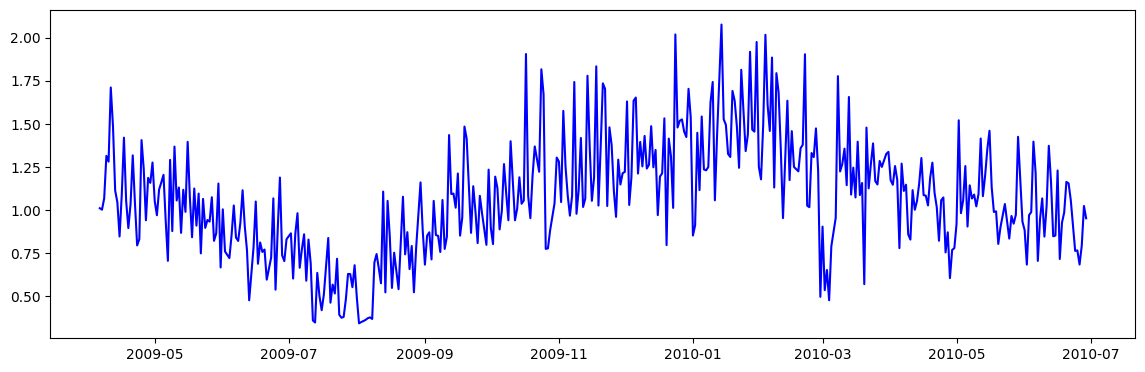

In [14]:
if isinstance(df.index, pd.DatetimeIndex) and len(df.index) > 1:
    delta = df.index[1] - df.index[0]
    forward_index = [df.index[-1] + (i + 1) * delta for i in range(pred_len)]
    backward_index = [df.index[0] - (pred_len - i) * delta for i in range(pred_len)]
else:
    forward_index = np.arange(len(df), len(df) + pred_len)
    backward_index = np.arange(-pred_len, 0)

plt.figure(figsize=(14, 5 * n_features))

for i, col in enumerate(df.columns):
    ax = plt.subplot(n_features, 1, i + 1)
    ax.plot(df.index, df[col].values, label='Исторические данные', color='blue')
    ax.plot(df_pred_both.index, df_pred_both[col].values, label='Прогнозы назад и вперед', color='red')
    ax.axvline(df.index[0], color='gray', linestyle='--', alpha=0.5)
    ax.axvline(df.index[-1], color='gray', linestyle='--', alpha=0.5)
    ax.set_title(f'Признак: {col}')
    ax.legend()

plt.tight_layout()
plt.show()